In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint



Using TensorFlow backend.


In [3]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
    print(df.head())
    intent = df["Intent"]
    unique_intent = list(set(intent))
    sentences = list(df["Sentence"])
  
    return (intent, unique_intent, sentences)
  


In [4]:
intent, unique_intent, sentences = load_dataset("data.csv")

                    Sentence   Intent
0  How many <item> are left?  balance
1           Stock of <Item>?  balance
2        Do you have <Item>?  balance
3         Balance of <Item>?  balance
4           Any <Item> left?  balance


In [5]:
print(sentences[:5])

['How many <item> are left?', 'Stock of <Item>?', 'Do you have <Item>?', 'Balance of <Item>?', 'Any <Item> left?']


In [6]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/axelalvarsson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/axelalvarsson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#define stemmer
stemmer = LancasterStemmer()

In [8]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words  

In [9]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  
  


118
[['how', 'many', 'item', 'are', 'left'], ['stock', 'of', 'item']]


In [10]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    print(token)
    return token

In [11]:
def max_length(words):
    return(len(max(words, key = len)))
  

In [12]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 82 and Maximum length = 9


In [13]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [14]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)
#print(encoded_doc)

In [15]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [16]:
padded_doc = padding_doc(encoded_doc, max_length)

In [17]:
padded_doc[:5]

array([[ 3, 22,  1,  7, 13,  0,  0,  0,  0],
       [ 9,  4,  1,  0,  0,  0,  0,  0,  0],
       [14,  2, 28,  1,  0,  0,  0,  0,  0],
       [34,  4,  1,  0,  0,  0,  0,  0,  0],
       [29,  1, 13,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [18]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (118, 9)


In [19]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [20]:
output_tokenizer.word_index

{'price': 1, 'order': 2, 'balance': 3, 'common': 4}

In [21]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [22]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [23]:
encoded_output.shape

(118, 1)

In [24]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [25]:
output_one_hot = one_hot(encoded_output)

/Users/axelalvarsson/opt/anaconda3/envs/nnlm/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [26]:
output_one_hot.shape

(118, 4)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)


In [29]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (94, 9) and train_Y = (94, 4)
Shape of val_X = (24, 9) and val_Y = (24, 4)


In [30]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = True))
    model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))
  
    return model





In [31]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 128)            10496     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 282,020
Trainable params: 282,020
Non-trainable params: 0
_________________________________________________________________


In [32]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_X, train_Y, epochs = 200, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

/Users/axelalvarsson/opt/anaconda3/envs/nnlm/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 94 samples, validate on 24 samples
Epoch 1/200
94/94 [==============================] - 4s 47ms/step - loss: 1.3855 - accuracy: 0.2660 - val_loss: 1.3766 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 1.37661, saving model to model.h5
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3789 - accuracy: 0.1915 - val_loss: 1.3656 - val_accuracy: 0.4167

Epoch 00002: val_loss improved from 1.37661 to 1.36564, saving model to model.h5
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3655 - accuracy: 0.3723 - val_loss: 1.3542 - val_accuracy: 0.5417

Epoch 00003: val_loss improved from 1.36564 to 1.35423, saving model to model.h5
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3611 - accuracy: 0.3298 - val_loss: 1.3386 - val_accuracy: 0.4167

Epoch 00004: val_loss improved from 1.35423 to 1.33859, saving model to model.h5
Epoch 5/200
94/94 [==============================] - 0s 3ms/step - 


Epoch 00040: val_loss did not improve from 0.49168
Epoch 41/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.7082 - val_accuracy: 0.9167

Epoch 00041: val_loss did not improve from 0.49168
Epoch 42/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.7418 - val_accuracy: 0.9167

Epoch 00042: val_loss did not improve from 0.49168
Epoch 43/200
94/94 [==============================] - 1s 6ms/step - loss: 0.0159 - accuracy: 0.9894 - val_loss: 0.7545 - val_accuracy: 0.9167

Epoch 00043: val_loss did not improve from 0.49168
Epoch 44/200
94/94 [==============================] - 0s 4ms/step - loss: 0.0423 - accuracy: 0.9787 - val_loss: 0.7766 - val_accuracy: 0.8750

Epoch 00044: val_loss did not improve from 0.49168
Epoch 45/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0385 - accuracy: 0.9894 - val_loss: 0.7968 - val_accuracy: 0.8750

Epoch 00045: val_loss did not

94/94 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.6864 - val_accuracy: 0.8750

Epoch 00083: val_loss did not improve from 0.49168
Epoch 84/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9894 - val_loss: 0.7125 - val_accuracy: 0.8750

Epoch 00084: val_loss did not improve from 0.49168
Epoch 85/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9787 - val_loss: 0.7399 - val_accuracy: 0.8750

Epoch 00085: val_loss did not improve from 0.49168
Epoch 86/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9894 - val_loss: 0.7685 - val_accuracy: 0.8750

Epoch 00086: val_loss did not improve from 0.49168
Epoch 87/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9894 - val_loss: 0.7982 - val_accuracy: 0.8750

Epoch 00087: val_loss did not improve from 0.49168
Epoch 88/200
94/94 [=======================

94/94 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 1.1005 - val_accuracy: 0.8333

Epoch 00125: val_loss did not improve from 0.49168
Epoch 126/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.0832 - val_accuracy: 0.8333

Epoch 00126: val_loss did not improve from 0.49168
Epoch 127/200
94/94 [==============================] - 0s 2ms/step - loss: 5.6686e-04 - accuracy: 1.0000 - val_loss: 1.0708 - val_accuracy: 0.8333

Epoch 00127: val_loss did not improve from 0.49168
Epoch 128/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.0660 - val_accuracy: 0.8333

Epoch 00128: val_loss did not improve from 0.49168
Epoch 129/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9894 - val_loss: 1.0668 - val_accuracy: 0.8333

Epoch 00129: val_loss did not improve from 0.49168
Epoch 130/200
94/94 [==============

94/94 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.1900 - val_accuracy: 0.8750

Epoch 00167: val_loss did not improve from 0.49168
Epoch 168/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.2020 - val_accuracy: 0.8750

Epoch 00168: val_loss did not improve from 0.49168
Epoch 169/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9894 - val_loss: 1.2179 - val_accuracy: 0.8750

Epoch 00169: val_loss did not improve from 0.49168
Epoch 170/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.2309 - val_accuracy: 0.8750

Epoch 00170: val_loss did not improve from 0.49168
Epoch 171/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9894 - val_loss: 1.2422 - val_accuracy: 0.8750

Epoch 00171: val_loss did not improve from 0.49168
Epoch 172/200
94/94 [==================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


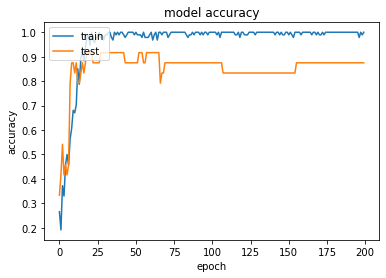

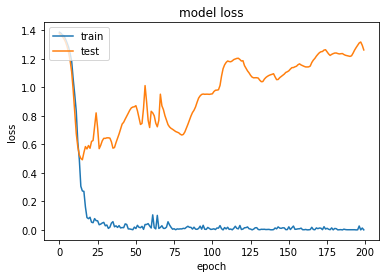

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
 model = load_model("model.h5")

/Users/axelalvarsson/opt/anaconda3/envs/nnlm/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [35]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    print(test_word)
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict_proba(x)
  
  
    return pred


  

In [36]:
def get_final_output(pred, classes):
    predictions = pred[0]
 
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
 
    for i in range(pred.shape[1]):
        print("%s has confidence = %s" % (classes[i], (predictions[i])))



In [37]:
#Price
text = "How much does it cost?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['how', 'much', 'does', 'it', 'cost']
price has confidence = 0.9295274
balance has confidence = 0.070433706
order has confidence = 3.834743e-05
common has confidence = 5.215025e-07


In [38]:
#Balance
text = "how many pants are in stock?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['how', 'many', 'pants', 'are', 'in', 'stock']
balance has confidence = 0.98781675
price has confidence = 0.012177299
common has confidence = 5.8738033e-06
order has confidence = 8.942432e-08


In [39]:
#Order
text = "I want to buy 3 pants"
pred = predictions(text)
get_final_output(pred, unique_intent)

['i', 'want', 'to', 'buy', '3', 'pants']
order has confidence = 0.89656526
price has confidence = 0.08742738
common has confidence = 0.008532433
balance has confidence = 0.007474897


In [40]:
#Common
text = "I need help"
pred = predictions(text)
get_final_output(pred, unique_intent)

['i', 'need', 'help']
common has confidence = 0.9746465
order has confidence = 0.017818842
price has confidence = 0.0052660275
balance has confidence = 0.0022686257


In [41]:
opening_lines = ['Hello, what can I help you with?',
                'How can I help you?',
                'Whats on your mind today?']

def randomOpening():
    index = random.randint(0,len(opening_lines)-1)
    print(opening_lines[index])



In [ ]:
def cli():
    while True:
        randomOpening()
        user_input = input("Ask the chatbot something: ")
        print(user_input)
        if(user_input=="quit"):
            break
        else:
            pred = predictions(user_input)
            print(pred)
            get_final_output(pred, unique_intent)

        
cli()

Hello, what can I help you with?
